# Setup

In [ ]:
#l = list(df_genes.columns.sort_values())
#[i for i in l if i.startswith("GD")]


clinical = ["L1CAM"]  # GD2 not in dataset
novel_targets = ["GPC2", "CD276", "ALK", "NCAM1"]

promising = pd.DataFrame()
promising["name"] = clinical + novel_targets + other_targets
promising["cat"] = (
    ["clinical"] * len(clinical)
    + ["novel"] * len(novel_targets)
)
promising = promising.set_index("name")
promising

In [ ]:
def df_from(selection):
    data = df[selection]
    data = pd.concat([df_classif, data], axis=1)
    data["tpm_sum"] = data.sum(axis=1, numeric_only=True)
    return data

def score_by_group_ind(selection, key="single"):
    df_scores = pd.DataFrame(data=None, index=h_tissues)
    dfs = [score_by_group(gene, key).rename(gene) for gene in selection]
    return pd.concat(dfs, axis=1)

,single,complete,median,average,quartile,quantile
Adipose - Subcutaneous,-3.961644,6.100055,0.440773,0.603771,-0.601440,-0.967576
Muscle - Skeletal,-2.840749,6.463368,1.527667,1.611642,0.631929,0.314877
Artery - Tibial,-3.726392,6.386471,1.656757,1.717650,0.808003,0.218178
Artery - Coronary,-3.351025,6.320706,1.092232,1.168798,-0.017974,-0.196564
Heart - Atrial Appendage,-3.207480,5.993496,0.708229,0.907351,-0.080371,-0.292193


single     -7.880319
complete    2.580623
median     -3.966299
average    -3.605044
quartile   -4.969281
quantile   -5.212618
dtype: float64

<AxesSubplot:title={'center':'5 selected antigens: MFI2, RTN4R, TDGF1, RAET1L, RTN4RL1'}, xlabel='tissue', ylabel='tpm_sum'>

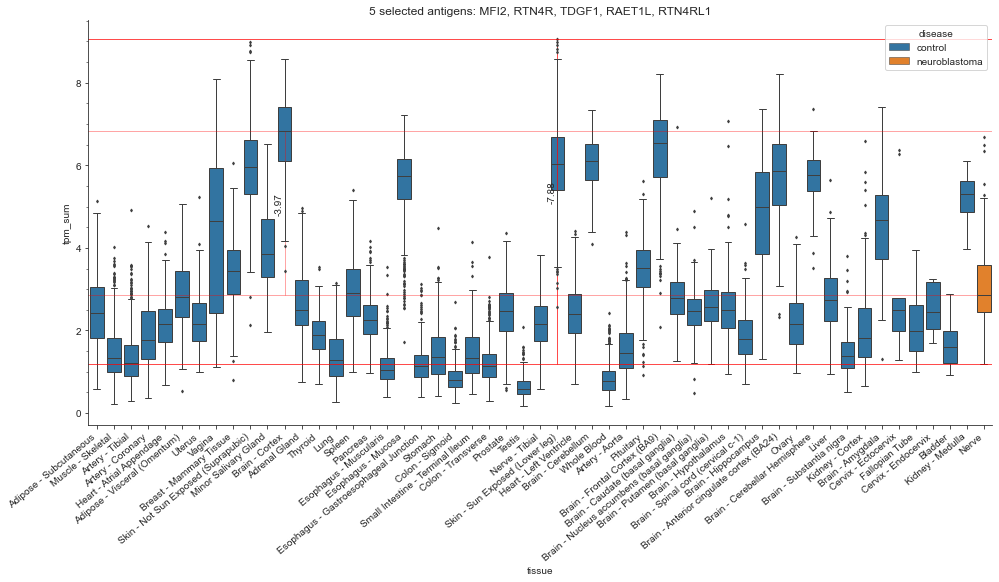

In [40]:
sel = list(df_genes.columns)[0:5]
scoring.score_by_group(sel).head()
scoring.score(sel)
plotting.boxplot(sel)

# Single gene analysis

In [ ]:
%%time
scores_avg = score_by_group_ind(df_genes.columns, 'average')
scores_single = score_by_group_ind(df_genes.columns, 'single')
scores_avg.head()
scores_single.head()

In [ ]:
promising["avg_mean"] = scores_avg.mean()[promising.index]
promising["avg_min"] = scores_avg.min()[promising.index]
promising["single_mean"] = scores_single.mean()[promising.index]
promising["single_min"] = scores_single.min()[promising.index]
promising
sns.heatmap(promising.iloc[:, 1:], cmap="vlag")

In [ ]:
boxplot(["L1CAM"])

In [ ]:
avg_best = scores_avg.mean().sort_values(ascending=False).head(10)

In [ ]:
import numpy as np


def select_genes(scores, quantile=0.25, percentage=0.8):
    threshold = np.quantile(scores.values, quantile)
    gs = scores.apply(lambda x: x > threshold).sum()
    t = np.floor(percentage * len(tissues))
    sel = gs[gs >= t].index
    return sel

In [ ]:
sel = select_genes(scores_avg, quantile=0.90, percentage=0.99)
set(promising.index) - set(sel)
set(best_sel) - set(sel)
len(sel)
1 - (len(sel) / len(scores_avg.columns))

In [ ]:
import itertools
from tqdm import tqdm

sols = []
for combination in tqdm(itertools.combinations(sel, 5)):
    s = score_single(list(combination))
    if s > 3.5:
        sols.append((*combination, s))

In [ ]:
sorted(sols, key=lambda x: (x[-1]), reverse=True)

In [ ]:
score_by_group_ind(sel).mean().sort_values(ascending=False).head(50)

# Machine Learning - Random Forest, SVM etc.

In [ ]:
from sklearn.model_selection import train_test_split

X = df_genes
# X = df_genes[sel]
y = df["disease"]
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm
import random


def save_results(sols, run_dir, n_feat):
    states = sols["state"]
    sols = sols[range(n_feat)]
    sols = sort_genes(sols)
    metrics = sols[range(n_feat)].apply(score, axis=1)
    sm = pd.concat([sols, metrics, states], axis=1).sort_values(by="single")
    sm.to_csv(os.path.join(run_dir, "best_sols.csv"), index=False)


# 0
random.seed(a=42)
for n_feat in [5, 10, 20]:  # [5, 10, 20]:
    sols = []
    states = []
    run_dir = create_run_dir("rf", n_feat)
    for i in tqdm(range(10)):
        state = random.randint(1000, 100000)
        
        clf = RandomForestClassifier(n_jobs=5, random_state=i)  # 128
        sel = SelectFromModel(clf, max_features=n_feat)
        sel = sel.fit(X_train, y_train)
        selected_feat = list(X_train.columns[(sel.get_support())])
        
        sols.append(selected_feat)
        states.append(str(state))
        
        df_sols = pd.DataFrame(sols)
        df_sols["state"] = states
        save_results(df_sols, run_dir, n_feat)

In [ ]:
clf.score(X_test, y_test)

clf = RandomForestClassifier(n_jobs=5)
clf = clf.fit(X_train[selected_feat], y_train)
clf.score(X_test[selected_feat], y_test)

# Collect results

In [ ]:
sols = pd.read_csv("best_sols.csv")
sols = clean_and_eval([sols], 10)
sols

In [1]:
import os
import re
import glob


def clean_and_eval(dfs, num_genes):
    sols = pd.concat(dfs)
    sols = sols[[str(i) for i in range(num_genes)]]
    sols = sols.drop_duplicates()
    metrics = sols.apply(score, axis=1)
    sols = pd.concat([sols, metrics], axis=1)
    sols = sols.sort_values(by="single", ascending=False)
    return sols


def get_sols(num_genes, metrics):
    runs_dir = os.path.join(".", "runs")
    runs = next(os.walk(runs_dir))[1]
    runs = list(
        filter(
            lambda x: f"_{num_genes}" in x and any(metric in x for metric in metrics),
            runs,
        )
    )
    print(runs)
    runs = [os.path.join(runs_dir, run_dir, "best_sols.csv") for run_dir in runs]
    dfs = []
    for run in runs:
        dfs.append(pd.read_csv(run))

    sols = clean_and_eval(dfs, num_genes)
    sols.to_csv(os.path.join(".", "eval", f'{num_genes}_{"_".join(metrics)}.csv'))
    return sols


#sols1 = get_sols(5, ["single"])
#sols2 = get_sols(10, ["single"])
#sols.head()

In [ ]:
sols[sols.single > 0].sort_values("average").tail(5)

In [2]:
%%time

for n in [5, 10, 20]:
    sols = get_sols(n, scoring.linkage_map.keys())
    sols.head()
    boxplot(sols.iloc[0, :n])

for n in [5, 10, 20]:
    sols = get_sols(n, ["rf"])
    sols.head()
    boxplot(sols.iloc[0, :n])

for n in [5, 10, 20]:
    sols = get_sols(n, ["rf"] + list(scoring.linkage_map.keys()))
    sols.head()
    boxplot(sols.iloc[0, :n])

NameError: name 'scoring' is not defined

# Eval

## Load results

In [5]:
import os
import pandas as pd

eval_dir = os.path.join("..", "eval")
filenames = next(os.walk(eval_dir))[2]
print(filenames)
dfs = []
for n in [5, 10, 20]:
    temp1 = pd.read_csv(f"../eval/{n}_rf.csv")
    temp1["approach"] = "rf"
    temp2 = pd.read_csv(
        f"../eval/{n}_single_single_rel_complete_complete_rel_median_median_rel_average_average_rel_quartile_quantile.csv"
    )
    temp2["approach"] = "ga"
    dfs.append(
        pd.concat([temp1, temp2]).iloc[:, 1:].sort_values("single", ascending=False)
    )

dfs[0].sort_values("average", ascending=False).head(10)

['10_rf.csv', '10_rf_single_single_rel_complete_complete_rel_median_median_rel_average_average_rel_quartile_quantile.csv', '10_single.csv', '10_single_complete_median_average_quartile_quantile.csv', '10_single_single_rel_complete_complete_rel_median_median_rel_average_average_rel_quartile_quantile.csv', '20_rf.csv', '20_rf_single_single_rel_complete_complete_rel_median_median_rel_average_average_rel_quartile_quantile.csv', '20_single_complete_median_average_quartile_quantile.csv', '20_single_single_rel_complete_complete_rel_median_median_rel_average_average_rel_quartile_quantile.csv', '5_rf.csv', '5_rf_single_single_rel_complete_complete_rel_median_median_rel_average_average_rel_quartile_quantile.csv', '5_single.csv', '5_single_complete_median_average_quartile_quantile.csv', '5_single_single_rel_complete_complete_rel_median_median_rel_average_average_rel_quartile_quantile.csv']


,0,1,2,3,4,single,single_rel,complete,complete_rel,median,median_rel,average,average_rel,quartile,quantile,approach
879,CD44,CHRNA3,KCNQ2,NCAM1,NTRK1,-5.344576,0.507742,24.321030,10.217832,14.082312,4.764629,13.868790,4.710420,9.620579,12.206576,ga
899,CD276,CHRNA3,GPC2,KCNQ2,NTRK1,-7.216567,0.240273,22.005492,12.437073,13.651855,5.821822,13.306169,5.708173,10.999323,11.065290,ga
904,CHRNA3,GPC2,KCNQ2,NCAM1,NTRK1,-7.628407,0.238514,23.137079,8.711441,13.329811,4.508606,13.147825,4.480362,10.290838,11.877768,ga
890,CD276,CHRNA3,GPC2,KCNQ2,NCAM1,-6.035012,0.289942,20.815279,7.317597,13.490781,4.104637,13.053185,4.037883,11.159532,11.729999,ga
906,CD44,CHRNA3,L1CAM,NTRK1,SLC29A4,-7.922261,0.406742,25.100501,8.565092,13.557281,3.960448,12.894763,3.805943,9.157446,11.340386,ga
616,CD44,CHRNA3,KCNQ2,NCAM1,VEZT,-0.950750,0.886014,22.218093,8.449671,12.936022,4.229579,12.872106,4.215962,9.846484,11.117636,ga
917,CHRNA3,GPC2,L1CAM,NCAM1,NTRK1,-9.031711,0.210162,23.638907,6.692274,12.924992,3.391796,12.648163,3.368805,10.047875,12.343844,ga
919,CD276,CHRNA3,CHRNA7,KCNQ2,NTRK1,-9.336491,0.072563,22.960057,15.323624,13.292589,6.512583,12.637598,5.842148,9.647596,10.209581,ga
901,CHRNA3,KCNQ2,NCAM1,NTRK1,PTK7,-7.428598,0.273884,23.115461,9.246615,12.762424,4.247499,12.567168,4.224734,9.701977,11.403689,ga
759,CHRNA3,GPC2,HM13,KCNQ2,NCAM1,-2.914979,0.667576,19.029033,5.966116,12.884395,3.545495,12.524281,3.501748,11.044673,11.390234,ga


In [10]:
sols = clean_and_eval([dfs[0]], 5)
dfs[0].sort_values("single", ascending=False).head(10)

,0,1,2,3,4,single,single_rel,complete,complete_rel,median,median_rel,average,average_rel,quartile,quantile,approach
0,ATP6AP2,CD99,KCNQ2,SMPD4,VEZT,5.063818,1.713584,13.093142,3.563408,8.668583,2.382718,8.697351,2.395250,7.732128,8.245998,ga
1,CD276,CD99,CLN3,KCNQ2,MARCH6,4.861751,1.625339,12.993399,3.447934,9.056395,2.435971,9.049559,2.435420,7.885054,8.267292,ga
2,CD99,CHRNA7,KCNQ2,SMPD4,VEZT,4.808283,1.873641,14.546920,4.956760,9.260378,3.132081,9.303375,3.143846,8.026950,8.621890,ga
3,CD99,KCNQ2,LMBR1,SMPD4,VEZT,4.750235,1.790281,12.700436,4.060890,8.459247,2.718547,8.516660,2.730893,7.582120,7.900005,ga
4,CD99,CLN3,KCNQ2,MARCH6,VEZT,4.672258,1.682019,12.832848,3.977890,8.581561,2.537972,8.598082,2.535485,7.569527,7.847307,ga
5,ATP6AP2,CLPTM1L,L1CAM,PTK7,VEZT,4.668935,1.623690,13.947769,3.901678,9.208917,2.543234,9.224762,2.554698,8.029495,8.324883,ga
6,CD99,CHRNA7,KCNQ2,LRBA,VEZT,4.654674,1.953682,14.601395,6.094205,8.509511,3.195457,8.681923,3.259317,7.459802,7.911743,ga
7,CD99,CHRNA7,CLN3,KCNQ2,VEZT,4.626340,1.923030,13.904301,6.186679,8.843852,3.309080,8.860863,3.318981,7.621543,8.200559,ga
8,ATP6AP2,CLN3,CLPTM1L,LIG1,NCAM1,4.580741,1.595940,13.197518,3.702766,9.094114,2.516390,8.970714,2.490397,7.895631,7.954114,ga
9,CD99,CLN3,GDPD1,KCNQ2,VEZT,4.559505,1.881148,11.646414,4.637527,8.303894,3.012239,8.257461,3.012706,7.298482,7.632095,ga


In [ ]:
boxplot(
    dfs[2][dfs[2].approach == "ga"]
    .sort_values("single", ascending=False)
    .head(10)
    .iloc[0, 0:20]
    .values
)

In [ ]:
sns.set_style("ticks")
boxplot(
    dfs[0].sort_values("average", ascending=False).head(5).iloc[0, 0:5].values,
    "eval/pres/avg1.svg",
)
boxplot(
    dfs[0].sort_values("average", ascending=False).head(5).iloc[1, 0:5].values,
    "eval/pres/avg2.svg",
)
boxplot(
    dfs[0].sort_values("single", ascending=False).head(5).iloc[0, 0:5].values,
    "eval/pres/single1.svg",
)
boxplot(
    dfs[0].sort_values("single", ascending=False).head(5).iloc[1, 0:5].values,
    "eval/pres/single2.svg",
)
boxplot(
    sols1.sort_values("average", ascending=False).head(5).iloc[0, 0:5].values,
    "eval/pres/mix1.svg",
)
boxplot(
    sols1.sort_values("average", ascending=False).head(5).iloc[1, 0:5].values,
    "eval/pres/mix2.svg",
)

## Melt solution dfs

In [ ]:
ag_cols = list(range(20))
linkages = linkage_map.keys()


def asdf(df, approach, n, diff, sort_by):
    # df["x"] = (df["single"] + df["average"]) / 2
    subset = df[df.approach == approach].sort_values(sort_by).tail(n)
    subset = subset.reset_index(drop=True).reset_index()
    subset = pd.melt(subset, id_vars=list(linkages) + ["approach", "index"])
    subset = subset.rename({"index": "solution_id"}, axis=1)
    subset = subset[subset.variable != "x"]
    size = subset.variable.astype("int").max()
    subset["sol_size"] = size + 1
    # subset = subset.drop("variable", axis=1)
    if diff:
        subset = subset[subset["value"].isin(diff)]
    return subset


def _melt(df, n=None, diff=None, sort_by=None):
    n = len(df) if not n else n
    ss1 = asdf(df, "ga", n, diff, sort_by)
    ss2 = asdf(df, "rf", n, diff, sort_by)
    ss2.loc[:, "solution_id"] = ss2.loc[:, "solution_id"] + n

    return pd.concat([ss1, ss2], ignore_index=True)


def melt(dfs, n=None, diff=None, sort_by="single"):
    tmp = []
    for df in dfs:
        tmp.append(_melt(df, n, diff, sort_by))
    return pd.concat(tmp)


def melt_uniq(dfs, n=None, diff=None, sort_by="single"):
    m = melt(dfs, n, diff, sort_by)
    m.loc[m.sol_size == 10, "solution_id"] = m.loc[m.sol_size == 10, "solution_id"] + n
    m.loc[m.sol_size == 20, "solution_id"] = (
        m.loc[m.sol_size == 20, "solution_id"] + 2 * n
    )
    return m

In [ ]:
sols1["approach"] = "ga"
m1 = sols1[sols1.single > 0]
sols2["approach"] = "ga"
m2 = sols2[sols2.single > 0]
m = melt_uniq([m1, m2], 10, sort_by="average")
m

In [ ]:
eval_df_full = melt(dfs)
n_sols = 10
ds = dfs[0:2]
eval_df_best_s = melt_uniq(ds, n_sols, sort_by="single")
eval_df_best_a = melt_uniq(ds, n_sols, sort_by="average")
eval_df_best_s["average"].mean()
eval_df_best_a["average"].mean()
eval_df_best_s["single"].mean()
eval_df_best_a["single"].mean()

In [ ]:
for df in dfs:
    df.sort_values("single").tail(10)

## Individual solutions

In [ ]:
def pivot(data, approach=None):
    if approach:
        piv = (
            data[data.approach == approach]
            .groupby(["sol_size", "solution_id", "value"])
            .size()
            .reset_index()
            .pivot(columns=["sol_size", "solution_id"], index="value", values=0)
        )
    else:
        piv = (
            data.groupby(["approach", "sol_size", "solution_id", "value"])
            .size()
            .reset_index()
            .pivot(
                columns=["sol_size", "approach", "solution_id"], index="value", values=0
            )
        )
    s = piv.sum(axis=1)
    s = s.sort_values(ascending=False)
    piv = piv.reindex(s.index)
    piv = piv.fillna(0)
    piv = piv.head(15)
    return piv


# sns.heatmap(piv)
# df_plot.to_csv("piv_new.csv")
best_sel = piv.index
# piv1 = pivot(eval_df_best_s, "ga")
# piv1
pivot(eval_df_best_s, "ga").to_csv("piv_s_ga.csv")
pivot(eval_df_best_s, "rf").to_csv("piv_s_rf.csv")
pivot(eval_df_best_a, "ga").to_csv("piv_a_ga.csv")
pivot(eval_df_best_a, "rf").to_csv("piv_a_rf.csv")
pivot(m, "ga").to_csv("piv_a_sga.csv")
# piv1.to_csv("piv_ga.csv")
# piv2.to_csv("piv_rf.csv")
# piv1
# promising.loc[set(promising.index) - set(piv1.index)]
# promising.loc[set(promising.index).intersection(set(piv1.index))]
# piv2
# pivot(eval_df_best_s)
# pivot(eval_df_best_a)

In [ ]:
import random

s = len(eval_df_best["value"].unique())
a = sns.color_palette("Paired")
# col = a + sns.color_palette("hls", s - len(a))
col = sns.color_palette("Spectral", s)
col = sns.color_palette("Set1") + sns.color_palette("Set2")

assert len(col) >= s
random.shuffle(col)

ax = df_plot.plot(kind="barh", stacked=True, figsize=(10, 10), color=col, legend=False)
# plt.axis("off")


def annotateBars(row, ax=ax):
    # print(row)
    curr_value = 0
    for col in row.index:
        value = row[col]
        if str(value) != "nan":
            _ = ax.text(
                curr_value + (value) / 2,
                row.name,
                str(col),
                ha="center",
                va="center",
            )
            curr_value += value


_ = df_plot.apply(annotateBars, ax=ax, axis=1)

In [ ]:
import numpy as np

# fil = eval_df_best[eval_df_best.sol_size < 10]
# fil = dfs[0].iloc[:30]
fil = melt_uniq(dfs[0:3], 10)
piv = pd.pivot_table(
    fil,
    values="single",
    index=["sol_size", "solution_id"],
    columns=["value"],
    aggfunc=np.any,
)
piv = piv.fillna(False)
s = piv.sum()
piv = piv[s.sort_values(ascending=False).index]
piv = piv[piv.columns[piv.sum() > 4]]
piv = piv.replace({True: 1, False: 0})
piv
sns.heatmap(piv.corr(), cmap="vlag")
# piv.to_csv("piv.csv")
# sns.heatmap(piv)
piv.corr().to_csv("corr2.csv")

## Solution quality distribution

### Generate random solutions

In [ ]:
dfs_rand = []
for n in [5, 10, 20]:
    rows = []
    for i in range(1000):
        rows.append(list(df_genes.sample(n, axis=1, random_state=i).columns))

    df_rand = pd.DataFrame.from_records(rows, columns=[str(x) for x in range(n)])
    dfs_rand.append(clean_and_eval([df_rand], n))

dfs_rand[0]

In [ ]:
for df in dfs_rand:
    df["approach"] = "random"

eval_df_rand = melt(dfs_rand)

In [ ]:
data_eval_full_with_rand = pd.concat([eval_df_full, eval_df_rand]).reset_index()
data_eval_full_with_rand

In [ ]:
from collections import Counter

In [ ]:
dfs[0].iloc[:20, 0:5].reset_index().pivot_table(
    index="index", columns=["0", "1", "2", "3", "4"], values=["index"], aggfunc=np.sum
)

In [ ]:
topk = 40
ag_names = dfs[0].iloc[:topk, 0:5].to_numpy().reshape(-1)
ag_indices = {ag[0]: i for i, ag in enumerate(Counter(ag_names).most_common())}
count_M = np.zeros((len(ag_indices), len(ag_indices)), dtype=int)

In [ ]:
for row in dfs[0].iloc[:topk, 0:5].to_numpy():
    for i in range(len(row)):
        for j in range(i + 1, len(row)):
            count_M[ag_indices[row[i]], ag_indices[row[j]]] += 1
            count_M[ag_indices[row[j]], ag_indices[row[i]]] += 1

In [ ]:
count_M.shape

In [ ]:
plt.imshow(np.log(count_M / count_M.max()))

In [ ]:
mask = np.triu(np.ones_like(count_M, dtype=bool))

plt.figure(figsize=(6, 6), dpi=140)
sns.heatmap(
    count_M,
    mask=mask | (count_M == 0),
    vmin=0,
    cmap=sns.color_palette("Blues", as_cmap=True),
    center=0,
    square=True,
    linewidths=0.1,
    cbar_kws={"shrink": 0.5},
)

### Plots

In [ ]:
x = data_eval_full_with_rand.drop_duplicates(subset=["approach", "sol_size", "index"])
x.groupby(["approach", "sol_size"]).size()

In [ ]:
import numpy as np

size = 850
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace), :]
x2 = x.groupby(["approach", "sol_size"], as_index=False).apply(fn)
x2.groupby(["approach", "sol_size"]).size()

In [ ]:
fn = lambda x: list(map(lambda y: y[-1], x))
x4 = x.iloc[fn(x.groupby(["approach", "sol_size"])["single"].nlargest(850).index)]
x4

In [ ]:
name_dict = {
    "single": "Single linkage distance",
    "average": "Average linkage distance",
    "sol_size": "Number of selected antigens",
    "approach": "Approach",
}
x3 = x2.rename(name_dict, axis=1)
x3["Approach"] = x3["Approach"].map(
    {"ga": "Genetic algorithm", "rf": "Random forest", "random": "Random"}
)
x3

In [ ]:
sns.set_style("whitegrid")
for linkage in ["single", "average"]:
    plot = sns.displot(
        data=x3,
        x=name_dict[linkage],
        col=name_dict["sol_size"],
        hue=name_dict["approach"],
        kind="kde",
        height=3,
    )
    plot.fig.savefig(f"dist_{linkage}.svg", format="svg", bbox_inches="tight")

In [ ]:
plot = sns.scatterplot(
    data=x3,
    x=name_dict["single"],
    y=name_dict["average"],
    hue=name_dict["approach"],
    s=5,
)
plot.get_figure().savefig("single_avg_corr.svg", format="svg", bbox_inches="tight")

In [ ]:
sns.heatmap(x4.corr())

In [ ]:
p = sns.relplot(
    data=x3,
    x=name_dict["single"],
    y=name_dict["average"],
    col=name_dict["sol_size"],
    hue=name_dict["approach"],
    height=4,
    aspect=1,
    s=5,
    # facet_kws={"sharey": False, "sharex": False},
)

p.get_figure().savefig('single_avg_corr.svg', format="svg", bbox_inches="tight")

In [ ]:
# x4 = x3[x3[name_dict["single"]] > 0]
p = sns.relplot(
    data=x4[(x4.approach == "ga") & (x4.sol_size == 5)],
    x="single",
    y="single_rel",
    col="sol_size",
    hue="approach",
    height=4,
    aspect=1,
    s=5,
    # facet_kws={"sharey": False, "sharex": False},
)

x4.groupby(["approach", "sol_size"]).corr()["single"].loc[:, :, "single_rel"]

## idk what this is

In [ ]:
def hist(df, diff=None):
    subset = _melt(df, diff)
    sns.set_style("darkgrid")
    plot = sns.histplot(x=subset["value"])
    _ = plt.setp(plot.get_xticklabels(), rotation=90)
    plot.get_figure().set_size_inches(15, 5)

In [ ]:
eval_df = melt(dfs, 50)
ags = eval_df["value"].unique()
len(ags)
eval_df.groupby(["approach", "sol_size"])["index"].max()
eval_df.drop_duplicates(["approach", "sol_size", "value"]).groupby(
    ["approach", "sol_size"]
).size()

In [ ]:
vc = eval_df.groupby(["approach", "sol_size"])["value"].value_counts()
pd.DataFrame(vc).rename({"value": "count"}, axis=1).reset_index().rename(
    {"value": "antigen"}, axis=1
).groupby(["approach", "sol_size"]).apply(
    lambda x: x.nlargest(10, "count")
).reset_index(
    drop=True
)

In [ ]:
for i in range(3):
    melt(dfs_best100[i])["index"].max()

In [ ]:
a = pd.read_csv("sga_eval.csv")
a = a.drop("Unnamed: 0", axis=1)
a = a.fillna(0)
a = a.melt(id_vars=["p", "q"], value_vars=["num sa", "num diff", "dropped"])
sns.lineplot(data=a, x="p", y="value", hue="variable")

In [ ]:
x["perc dropped"] = x["dropped"] / 291
x["perc selected"] = x["num sa"] / 3169

In [ ]:
x

In [ ]:
a = x
a = a.fillna(0)
a = a.melt(id_vars=["p", "q"], value_vars=["perc selected", "perc dropped"])
sns.lineplot(data=a, x="p", y="value", hue="variable")

In [ ]:
sns.lineplot(data=a, x="q", y="value", hue="variable")

In [ ]:
sns.jointplot(data=a, x="q", y="p", kind="hex", color="#4CB391")

In [ ]:
g = sns.scatterplot(
    data=x,
    x="q",
    y="p",
    hue="perc dropped",
)

In [ ]:
x.to_csv("sga_eval.csv")

In [ ]:
hist(dfs[0], diff)

In [ ]:
hist(dfs[1], diff)

In [ ]:
hist(dfs[2], diff)

In [ ]:
eval_df

In [ ]:
srt = eval_df.groupby("value").size().sort_values(ascending=False)

In [ ]:
srt

In [ ]:
%%time
sns.set_style('darkgrid')
plot = sns.catplot(
    data=eval_df, x="value", y="single", hue="index", kind="strip", row="sol_size", order=srt, sharey=False, aspect=3, s=6
)
plot.set_xticklabels(rotation=90)
for ax in plot.axes.flat:
    ax.grid(True, axis='both')

In [ ]:
df

In [ ]:
eval_df_full = pd.concat(
    [
        melt(dfs[0]),
        melt(dfs[1]),
        melt(dfs[2]),
    ]
).reset_index()

In [ ]:
dfs[0]

In [ ]:
%%time
plot = sns.catplot(
    data=eval_df, x="value", y="single", hue="value", row="sol_size", legend=False, kind="violin"
)
_ = plt.setp(plot.get_xticklabels(), rotation=90)
_ = plt.tight_layout()
plot.get_figure().set_size_inches(24, 24)

In [ ]:
a


subset = subset.drop("variable", axis=1)
a = subset.groupby("value").mean()
b = subset.groupby(["value"]).size()
subset = (
    pd.concat([a, b], axis=1).reset_index(level=["value"]).rename({0: "count"}, axis=1)
)
subset = subset.sort_values("count", ascending=False).reset_index(drop=True)
subset

# plot = sns.barplot(x=subset["value"], y=subset["count"])
# _ = plt.setp(plot.get_xticklabels(), rotation=90)
# plot.get_figure().set_size_inches(14, 4)
# plot
# prettify_axes(plot)

In [ ]:
ag_cols = ["0", "1", "2", "3", "4"]
subset = dfs[0]
subset = subset[subset["single"] > 3.5]
# subset
subset = subset.loc[:, ["0", "1", "2", "3", "4", "approach", "single", "median"]]
# subset

subset = pd.melt(subset, id_vars=["approach", "single", "median"], value_vars=ag_cols)
subset = subset.drop("variable", axis=1)
subset
subset = subset[subset["value"].map(subset["value"].value_counts()) > 3]
# subset.value[subset["value"].value_counts() > 5]
plot = sns.violinplot(
    data=subset, x="value", y="single", hue="approach", split=True, inner=None
)
_ = plt.setp(plot.get_xticklabels(), rotation=90)
plot.get_figure().set_size_inches(10, 5)
# plot
# prettify_axes(plot)

In [ ]:
subset = subset.join(subset.groupby("value").size().rename("count"), on="value")

In [ ]:
subset

In [ ]:
plot = sns.scatterplot(data=subset, x="value", y="single", size="count", sizes=(1, 400))
_ = plt.setp(plot.get_xticklabels(), rotation=90)
plot.get_figure().set_size_inches(20, 10)

# Trash

In [ ]:
df_genes = a
df = pd.concat([df_classif, df_genes], axis=1)

In [ ]:
df

In [ ]:
%%time
a = df_genes.apply(lambda x: 2**x - 1)

In [ ]:
import math
a.applymap(lambda x: math.log2(x+1))


In [ ]:
df_genes.head()

In [ ]:
l = list(df_genes.columns)
l.sort()
l